In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=transform,
    download=False
)
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=transform,
    download=False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.RandomRotation(10),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset_full = datasets.FashionMNIST(
    root="data", train=True, transform=transform_train, download=True)
test_dataset = datasets.FashionMNIST(
    root="data", train=False, transform=transform_test, download=True)

validation_split = 0.1
train_size = int((1 - validation_split) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.dropout_conv = nn.Dropout2d(0.25)
        # Convolutional block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        # Convolutional block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # [batch, 32, 28, 28]
        x = F.max_pool2d(x, 2)                  # [batch, 32, 14, 14]
        x = self.dropout_conv(x)
        
        x = F.relu(self.bn2(self.conv2(x)))     # [batch, 64, 14, 14]
        x = F.max_pool2d(x, 2)                  # [batch, 64, 7, 7]
        
        x = F.relu(self.bn3(self.conv3(x)))     # [batch, 128, 7, 7]
        x = F.max_pool2d(x, 2)                  # [batch, 128, 3, 3]
        
        x = x.view(x.size(0), -1)               # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = EnhancedCNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 25
train_losses = []
val_losses = []

start_time = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    
    scheduler.step()  
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

elapsed_time = time.time() - start_time
print(f"Total Training Time: {elapsed_time/60:.2f} minutes")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


1/40 1.6121 1.2205 67.90%
2/40 1.1971 1.0729 74.28%
3/40 1.0647 0.9654 80.10%
4/40 0.9952 0.9296 81.13%
5/40 0.9560 0.9087 82.70%
6/40 0.9210 0.8716 83.55%
7/40 0.8936 0.8522 84.68%
8/40 0.8698 0.8401 85.40%
9/40 0.8510 0.8049 87.13%
10/40 0.8367 0.8040 86.90%
11/40 0.8226 0.7999 87.55%
12/40 0.8154 0.7898 87.47%
13/40 0.8040 0.7839 88.17%
14/40 0.7928 0.7824 88.07%
15/40 0.7864 0.7754 88.28%
16/40 0.7801 0.7543 89.45%
17/40 0.7721 0.7565 89.38%
18/40 0.7681 0.7506 89.03%
19/40 0.7651 0.7452 89.55%
20/40 0.7571 0.7431 89.52%
21/40 0.7542 0.7280 90.48%
22/40 0.7484 0.7308 89.98%
23/40 0.7441 0.7295 90.52%
24/40 0.7400 0.7245 90.50%
25/40 0.7351 0.7274 90.35%
26/40 0.7351 0.7174 90.73%
27/40 0.7294 0.7077 91.17%
28/40 0.7280 0.7103 90.73%
29/40 0.7220 0.7110 91.48%
30/40 0.7210 0.7124 91.12%
31/40 0.7166 0.7070 91.33%
32/40 0.7147 0.7083 91.07%
33/40 0.7102 0.7052 91.27%
34/40 0.7109 0.7016 91.30%
35/40 0.7090 0.6983 91.43%
36/40 0.7088 0.6986 92.00%
37/40 0.7067 0.6977 91.83%
38/40 0.70

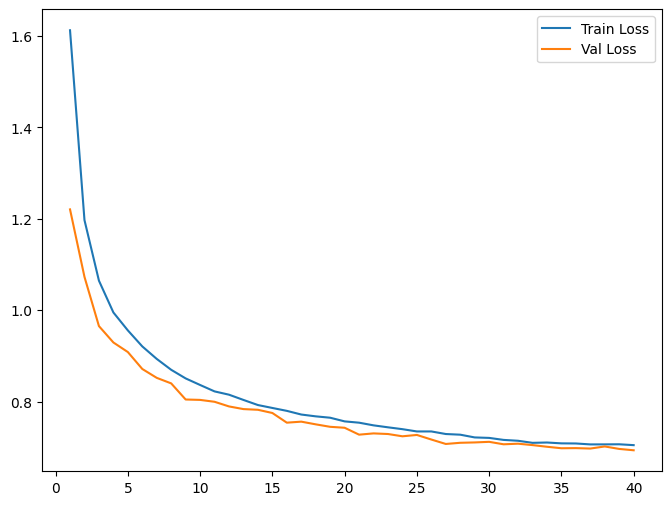

In [1]:
import time
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

def train_fn(m, l, o, sc, c, d):
    m.train()
    r = 0
    for x, y in l:
        x, y = x.to(d), y.to(d)
        o.zero_grad()
        out = m(x)
        loss = c(out, y)
        loss.backward()
        o.step()
        sc.step()
        r += loss.item()
    return r / len(l)

def val_fn(m, l, c, d):
    m.eval()
    r = 0
    acc = 0
    tot = 0
    with torch.no_grad():
        for x, y in l:
            x, y = x.to(d), y.to(d)
            out = m(x)
            loss = c(out, y)
            r += loss.item()
            _, p = torch.max(out, 1)
            tot += y.size(0)
            acc += (p == y).sum().item()
    return r / len(l), 100 * acc / tot

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1a = nn.Conv2d(1, 64, 3, 1, 1)
        self.b1a = nn.BatchNorm2d(64)
        self.c1b = nn.Conv2d(64, 64, 3, 1, 1)
        self.b1b = nn.BatchNorm2d(64)
        self.c2a = nn.Conv2d(64, 128, 3, 1, 1)
        self.b2a = nn.BatchNorm2d(128)
        self.c2b = nn.Conv2d(128, 128, 3, 1, 1)
        self.b2b = nn.BatchNorm2d(128)
        self.c3a = nn.Conv2d(128, 256, 3, 1, 1)
        self.b3a = nn.BatchNorm2d(256)
        self.c3b = nn.Conv2d(256, 256, 3, 1, 1)
        self.b3b = nn.BatchNorm2d(256)
        self.d = nn.Dropout2d(0.3)
        self.fc = nn.Linear(256, 10)
    def forward(self, x):
        x = F.relu(self.b1a(self.c1a(x)))
        x = F.relu(self.b1b(self.c1b(x)))
        x = F.max_pool2d(x, 2)
        x = self.d(x)
        x = F.relu(self.b2a(self.c2a(x)))
        x = F.relu(self.b2b(self.c2b(x)))
        x = F.max_pool2d(x, 2)
        x = self.d(x)
        x = F.relu(self.b3a(self.c3a(x)))
        x = F.relu(self.b3b(self.c3b(x)))
        x = F.max_pool2d(x, 2)
        x = self.d(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        return self.fc(x)

def main():
    set_seed(42)
    a = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(28, padding=4),
        transforms.RandomRotation(10),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3),
        transforms.Normalize((0.5,), (0.5,))
    ])
    b = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    d = datasets.FashionMNIST("data", True, a, download=True)
    d2 = datasets.FashionMNIST("data", False, b, download=True)
    v = 0.1
    t = int((1 - v) * len(d))
    v2 = len(d) - t
    ds, dv = torch.utils.data.random_split(d, [t, v2])
    l1 = torch.utils.data.DataLoader(ds, 64, True, num_workers=0, pin_memory=False)
    l2 = torch.utils.data.DataLoader(dv, 64, False, num_workers=0, pin_memory=False)
    l3 = torch.utils.data.DataLoader(d2, 64, False, num_workers=0, pin_memory=False)
    dev = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    m = Model().to(dev)
    c = nn.CrossEntropyLoss(label_smoothing=0.1)
    o = optim.AdamW(m.parameters(), lr=1e-3, weight_decay=1e-4)
    e = 40
    sp = len(l1)
    sc = optim.lr_scheduler.OneCycleLR(o, max_lr=1e-3, steps_per_epoch=sp, epochs=e, pct_start=0.2, anneal_strategy="cos", div_factor=25.0, final_div_factor=100.0)
    tl = []
    vl = []
    s = time.time()
    for i in range(e):
        r = train_fn(m, l1, o, sc, c, dev)
        w, q = val_fn(m, l2, c, dev)
        tl.append(r)
        vl.append(w)
        print(f"{i+1}/{e} {r:.4f} {w:.4f} {q:.2f}%")
    print(f"{(time.time()-s)/60:.2f}m")
    m.eval()
    acc = 0
    tot = 0
    with torch.no_grad():
        for x, y in l3:
            x, y = x.to(dev), y.to(dev)
            out = m(x)
            _, p = torch.max(out, 1)
            tot += y.size(0)
            acc += (p == y).sum().item()
    print(f"{100*acc/tot:.2f}%")
    scripted_model = torch.jit.script(m)
    torch.jit.save(scripted_model, "model_checkpoint.pt")
    plt.figure(figsize=(8,6))
    plt.plot(range(1,e+1), tl, label="Train Loss")
    plt.plot(range(1,e+1), vl, label="Val Loss")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
